In [1]:
import os
import sys
sys.path.append('../../')

In [2]:
%%capture
%pip install ultralytics

In [3]:
from  ultralytics import YOLO
import numpy as np

In [4]:
model = YOLO("../../models/detect_lanes_2.pt")
# 1 --> Orange
# 0 --> White

In [5]:
def detect_lanes(img_path, model):
    predictions = model.predict(source=img_path, save=False, conf=0.5)
    if predictions[0].masks is None:
        return None
    
    masks = predictions[0].masks.data
    cls = predictions[0].boxes.cls
    
    return (masks, cls)

In [6]:
def apex_from_mask(mask):
    height, width = mask.shape

    # Calculate the middle row index
    middle_row = height // 2

   # Initialize variables to track the indices of -1 values
    first_neg_one_idx = None
    last_neg_one_idx = None

    # Iterate over the rows from the middle row to the bottom row
    for y in range(middle_row, height):
        row = mask[y, :]
        # Check if there are any -1 values in the row
        if 1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == 1)[0][0]
                last_neg_one_idx = np.where(row == 1)[0][-1]
                print(first_neg_one_idx, last_neg_one_idx)
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                print(center_idx)
                return (line_idx, center_idx)
      
    for y in range(0, middle_row):
        row = mask[y, :]
        # Check if there are any -1 values in the row
        if 1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == 1)[0][0]
                last_neg_one_idx = np.where(row == 1)[0][-1]
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                return (line_idx, center_idx)

    return None

In [7]:
def get_resized_coordinates(point, original_shape, new_shape):
    x, y = point
    h_original, w_original = original_shape
    h_resized, w_resized = new_shape
    scale_factor_x = float(w_resized) / w_original
    scale_factor_y = float(h_resized) / h_original
    x_resized = round(x * scale_factor_x)
    y_resized = round(y * scale_factor_y)
    return (x_resized, y_resized)



In [8]:
def apex_from_lanes(masks=None, cls=None, orginial_size=(720,1280)):
    # Auxiliary parameters
    focus_mask = None

    # Breask if no lanes have been found
    if masks is None:
        return None
    
    
    # If an element of cls is equal to 1, return the corresponding mask
    for i, elt in enumerate(cls):
        if elt== 1:
            focus_mask = masks[i]
    
    if focus_mask is None:
        focus_mask = masks[0]
    
    h,w = focus_mask.shape
    
    apex = apex_from_mask(focus_mask)
    
    if apex is None:
        return None
    
    x,y = apex
    x,y = get_resized_coordinates((x,y), original_shape=focus_mask.shape, new_shape=orginial_size)
    
    plt.imshow(focus_mask, cmap="gray")
    
    return x,y


In [22]:
from skimage import io, draw
import numpy as np
from skimage.transform import resize


def draw_circle(img,x,y,r=5, color = [255, 0, 0]):
    x = int(x)
    y = int(y)
    """
    Draw a circle of radius r on the passed img 
    on coordinates (x,y)
    """
    mask = np.zeros_like(img[:, :, 0])
    rr, cc = draw.disk((x, y), r, shape=mask.shape)
    mask[rr, cc] = 1

    # Apply the mask to the image
    img[mask == 1, :] = color  # Set the circle color to red
    
    return img


In [10]:
def get_apex(model, img_path):
    res = detect_lanes(img_path, model)
    if res is None:
        return (0,0)
    masks, cls = res
    apex = apex_from_lanes(masks, cls, img.shape[:2])
    
    return apex

In [11]:
img_paths = [os.path.join("../../data/datasets/final_apex/test/apex", elt) for elt in os.listdir("../../data/datasets/final_apex/test/apex")]

In [12]:
import matplotlib.pyplot as plt

In [26]:
i = 10


image 1/1 /home/romain/Documents/roadfollower/scripts/data/datasets/final_apex/test/apex/57_124_872f9ce1-d399-11ed-99f0-fc4482a56b58.jpg: 640x640 1 white_lane, 1 orange_lane, 84.5ms
Speed: 0.7ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


57 124
122 162
142
(122, 54)


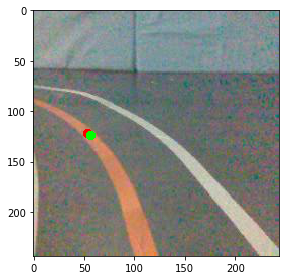

In [37]:
img_path = img_paths[i]
s = os.path.basename(img_path)
s = s.split("_")
x,y = s[0], s[1]
print(x,y)

i += 1
img = plt.imread(img_path)
apex = get_apex(model, img_path)
print(apex)


# Red - Prediction
img2 = draw_circle(img,apex[0], apex[1])

# Green - Ground Truth
img2 = draw_circle(img,y, x, color=[0,255,0])
io.imshow(img2)